# Are neighbourhoods with public transit in demand?
## An analysis of residential development permits in Calgary

For this project, I look at a dataset released by the City of Calgary. It contains 137,529 development permit applications for the years 1979-2019.
<br>
<br>
**Summary:** The goal of the project was to determine, whether there is more residential development in neighbourhoods with access to light rail transit (LRT) compared to areas without LRT access. The visualisations created here show that, indeed, there are more developments in areas close to transit. Unrelated to the original question, the analysis also showed a sharp increase in the number of secondary suites since 2018. Contractors and realtors may, thus, benefit from targeting homeowmers who are looking to develop secondary suites in their houses.
<br>
<br>
<u>Methodology:</u> First, the data was filtered to contain only residential developments, which were then grouped into three categories: houses, multi-unit buildings and secondary suites. Developments were subsequently grouped by neighbourhood and year. Annual growth rates were calculated for LRT and non-LRT communities. Growth rates were, then, visualised as bar charts, and the absolute number of permits was plotted as a density map.
<br>
<br>
<u>Results:</u> Initially, no difference was observed in the annual growth rates between LRT communities and non-LRT communities. This was also true when looking at houses, apartment buildings and secondary suites separately. This breakdown, however, showed that there was a marked increase in secondary suites as mentioned above.
<br>
Looking at the density of developments across neighbourhoods it did become apparent that the number of permits declines with distance from the city's train lines. Similarly, the communities with the highest levels of developments are located in close proximity to the train lines. This suggests that proximity to transit does create a moderate increase in demand.

## Imports

In [1]:
import io
import json
import pprint
import re

from PIL import Image

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim

from src import utils

%matplotlib inline


## Data pre-processing

### Initial EDA

In [2]:
permits_all = pd.read_csv('data/Development_Permits.csv', low_memory=False)
permits_all.head(25)


,point,PermitNum,Address,Category,Description,ProposedUseCode,ProposedUseDescription,PermittedDiscretionary,LandUseDistrict,LandUseDistrictDescription,...,Longitude,LocationCount,LocationTypes,LocationAddresses,LocationsGeoJSON,LocationsWKT,City Quadrants,Ward Boundaries 2017,Ward Boundaries,Calgary Communities
0,POINT (-114.121644748052 51.0588329703014),DP2018-5532,2624 7 AV NW,Relaxation - Existing - Residential,RELAXATION: DECK (EXISTING) - PROJECTION INTO ...,C1455,DECK,Discretionary,R-C2,Residential - Contextual One/Two Dwelling,...,-114.121645,2.0,Titled Parcel;Building,2624 7 AV NW;2624 7 AV NW,"{""type"":""MultiPoint"",""coordinates"":[[-114.1216...",MULTIPOINT (-114.121644748052 51.0588329703014...,2.0,7.0,7.0,280.0
1,POINT (-114.1628542098241 51.07974632228047),DP2019-3976,5223 22 AV NW,Residential - New Single / Semi / Duplex,REVISION: SINGLE DETACHED DWELLING (RETAINING ...,C1020; C2730,ACCESSORY RESIDENTIAL BUILDING; SINGLE DETACHE...,Discretionary,R-C1,Residential - Contextual One Dwelling,...,-114.162854,1.0,Titled Parcel,5223 22 AV NW,"{""type"":""Point"",""coordinates"":[-114.1628542,51...",POINT (-114.1628542098241 51.07974632228047),2.0,7.0,13.0,24.0
2,POINT (-114.20481737847645 51.153588405935935),DP2019-4525,2 ROYAL VISTA LI NW,Commercial - Other Areas,"NEW: OFFICE, RETAIL AND CONSUMER SERVICE (3 BU...",C2110; C2515; C2680; C2690; C2700,OFFICE; RETAIL AND CONSUMER SERVICE; SIGN - CL...,Discretionary,I-B f1.0h24,Industrial - Business,...,-114.204817,1.0,Titled Parcel,2 ROYAL VISTA LI NW,"{""type"":""Point"",""coordinates"":[-114.2048174,51...",POINT (-114.20481737847645 51.153588405935935),2.0,9.0,3.0,157.0
3,POINT (-114.06914327122048 51.00394391815661),DP2016-0294,307 55 AV SW,Residential - Multi-Family,"NEW: ASSISTED LIVING (1 BUILDING, 135 RESIDENCES)",C1110,ASSISTED LIVING,Discretionary,DC,Direct Control (1P2007),...,-114.069143,1.0,Titled Parcel,307 55 AV SW,"{""type"":""Point"",""coordinates"":[-114.0691433,51...",POINT (-114.06914327122048 51.00394391815661),1.0,11.0,10.0,124.0
4,POINT (-113.88270351988479 50.89784906501635),DP2016-4777,17100 104 ST SE,Change of Use - With Change to Site Plan,TEMPORARY USE: VEHICLE STORAGE - RECREATIONAL ...,C2980,VEHICLE STORAGE - RECREATIONAL,Discretionary,S-FUD,Special Purpose - Future Urban Development,...,-113.882704,1.0,Titled Parcel,17100 104 ST SE,"{""type"":""Point"",""coordinates"":[-113.8827035,50...",POINT (-113.88270351988479 50.89784906501635),3.0,8.0,4.0,205.0
5,POINT (-113.97858984984752 51.17343558287692),DP2016-3398,300 BARLOW CR NE,Change of Use - With Change to Site Plan,CHANGES TO SITE PLAN: OTHER (PRIVATE ACCESS ROAD),C9999,OTHER,Discretionary,C-R3 f0.23h18,Commercial - Regional 3,...,-113.978590,3.0,Titled Parcel;Titled Parcel;Titled Parcel,13440R 36 ST NE;300 BARLOW CR NE;100 BARLOW CR NE,"{""type"":""MultiPoint"",""coordinates"":[[-113.9785...",MULTIPOINT (-113.97858984984752 51.17343558287...,4.0,1.0,11.0,6.0
6,POINT (-114.10044232606693 51.02870602760652),DP2016-3403,1710 28 AV SW,Residential - Multi-Family,NEW: MULTI-RESIDENTIAL DEVELOPMENT (2 BUILDING...,C2050,MULTI-RESIDENTIAL DEVELOPMENT,Discretionary,M-C1,Multi-Residential - Contextual Low Profile,...,-114.100442,1.0,Titled Parcel,1710 28 AV SW,"{""type"":""Point"",""coordinates"":[-114.1004423,51...",POINT (-114.10044232606693 51.02870602760652),1.0,2.0,14.0,207.0
7,POINT (-114.06939124901527 51.05274350438137),DP2017-2972,404 2 AV SW,Change of Use - With Change to Site Plan,REVISION: PLAZA LANDSCAPING IN FLOOD FRINGE,B9997,OTHER COMMERCIAL,Discretionary,DC,DIRECT CONTROL DISTRICT ...,...,-114.069391,2.0,Titled Parcel;Titled Parcel,139 BARCLAY PR SW;404 2 AV SW,"{""type"":""MultiPoint"",""coordinates"":[[-114.0693...",MULTIPOINT (-114.06939124901527 51.05274350438...,1.0,7.0,7.0,295.0
8,POINT (-114.13530835885037 51.03424001568322),DP2017-3114,2212 33 ST SW,Residential - Contextual Dwelling,"NEW: CONTEXTUAL SEMI-DETACHED DWELLING, ACCESS...",C1020; C1368,ACCESSORY RESIDENTIAL BUILDI

In [3]:
permits_all.columns


Index(['point', 'PermitNum', 'Address', 'Category', 'Description',
       'ProposedUseCode', 'ProposedUseDescription', 'PermittedDiscretionary',
       'LandUseDistrict', 'LandUseDistrictDescription', 'Concurrent LOC',
       'StatusCurrent', 'AppliedDate', 'DecisionDate', 'ReleaseDate',
       'MustCommenceDate', 'CanceledRefusedDate', 'Decision', 'DecisionBy',
       'SDABNumber', 'SDABHearingDate', 'SDABDecision', 'SDABDecisionDate',
       'CommunityCode', 'CommunityName', 'Ward', 'Quadrant', 'Latitude',
       'Longitude', 'LocationCount', 'LocationTypes', 'LocationAddresses',
       'LocationsGeoJSON', 'LocationsWKT', 'City Quadrants',
       'Ward Boundaries 2017', 'Ward Boundaries', 'Calgary Communities'],
      dtype='object')

In [4]:
permits_all.shape


(137529, 38)

### Filter for relevant columns

The most relevant columns with respect to this analysis appear to be:
- `DecisionDate`
- `Decision`
- `Address`
- `CommunityName`
- `Latitude`
- `Longitude`
- and <b>one</b> of:
    - `Category`
    - `Description`
    - `ProposedUseDescription`

Together, these columns provide information about a development's year, its location and its type (i.e. residential vs. commercial). 

Regarding, the delveopment type, several columns could be relevant: `Category`, `Description` and `ProposedUseDescription`. These will be explored in the following section. The goal is to find a column with enough granularity to distinguish between different types of residential developments, while maintaining a workable number of unique values.

#### Select source column for development type

In [5]:
# 'Category' column
category_counts = utils.get_absolute_and_relative_counts(permits_all, 'Category')
category_counts.head()


,relative,absolute
NaN,0.411477,56590
Relaxation - Existing - Residential,0.107221,14746
Change of Use - Discretionary Use or Relaxations Required,0.056010,7703
Residential - New Single / Semi / Duplex,0.052847,7268
Home Occupation Class 2,0.049502,6808


- The `Category` column has too many missing values to be useful for this analysis.

In [6]:
# 'Description' column
description_counts = utils.get_absolute_and_relative_counts(permits_all, 'Description')
description_counts.head()


,relative,absolute
CONVERTED JOB - REAR DRIVE RELAXATION FOR EXISTING GARAGE,0.013430,1847
NEW: SINGLE DETACHED DWELLING,0.011154,1534
RELAXATION OF EXISTING STRUCTURE (RESIDENTIAL),0.010245,1409
CONVERTED JOB - SIDE YARD RELAXATION FOR EXISTING DWELLING,0.009976,1372
CONVERTED JOB - REAR YARD RELAXATION FOR EXISTING DECK,0.008878,1221


In [7]:
description_counts.tail()


,relative,absolute
CONVERTED JOB - TEMPORARY VISITOR PARKING LOT AT GRADE (5 YEARS),0.000007,1
CONVERTED JOB - HOME OCCUPATION - SCHOOL OF CHINESE ARTS & WATER COLOUR PAINTING (FIVE YEARS) (RENEWAL DP/91/0329),0.000007,1
CONVERTED JOB - 10 UNIT TOWNHOUSE COMPLEX,0.000007,1
CONVERTED JOB - COMMERCIAL BUILDING IN EXISTING SHOPPING CENTRE,0.000007,1
TEMPORARY USE: EXTENSIVE AGRICULTURE (7 MONTHS),0.000007,1


- The `Description` column has 58,189 unique categories, and the category with the highest frequency makes up only ~1% of the data. This column is not suited for this analysis.

In [8]:
# 'ProposedUseDescription' column
use_counts = utils.get_absolute_and_relative_counts(permits_all, 'ProposedUseDescription')
use_counts.shape


(2474, 2)

In [9]:
use_counts.head()


,relative,absolute
SINGLE-DETACHED DWELLING,0.196955,27087
HOME OCCUPATION - CLASS 2,0.071847,9881
SINGLE DETACHED DWELLING,0.052193,7178
ACCESSORY BUILDING,0.046608,6410
SIGN,0.041562,5716


In [10]:
use_counts.tail()


,relative,absolute
EXTERIOR RENOVATIONS; HOTEL,0.000007,1
LIQUOR STORE; SIGN - CLASS D; OTHER,0.000007,1
OFFICES; SIGN - CLASS B; SIGN - CLASS C,0.000007,1
FITNESS CENTRE; RESTAURANT: FOOD SERVICE ONLY - MEDIUM,0.000007,1
GENERAL INDUSTRIAL - LIGHT; OUTDOOR CAFE; RESTAURANT: LICENSED - MEDIUM; RETAIL AND CONSUMER SERVICE,0.000007,1


- The `ProposedUseType` column, still has 2474 unique categories, but many appear to have only few entries. It may be possible to drop these without compromising the analysis.

In [11]:
# Filter for categories that each make up less than .1% of the data. 
use_counts_low = use_counts[use_counts.relative < 0.001]
use_counts_low.head()


,relative,absolute
NEIGHBORHOOD SHOPPING CENTRE,0.000967,133
OUTSIDE STORAGE,0.000960,132
COMMUNITY ASSOCIATION BUILDING,0.000931,128
SPECIALTY FOOD STORE,0.000916,126
MEDICAL CLINIC; RETAIL AND CONSUMER SERVICE,0.000909,125


In [12]:
use_counts_low.tail()


,relative,absolute
EXTERIOR RENOVATIONS; HOTEL,0.000007,1
LIQUOR STORE; SIGN - CLASS D; OTHER,0.000007,1
OFFICES; SIGN - CLASS B; SIGN - CLASS C,0.000007,1
FITNESS CENTRE; RESTAURANT: FOOD SERVICE ONLY - MEDIUM,0.000007,1
GENERAL INDUSTRIAL - LIGHT; OUTDOOR CAFE; RESTAURANT: LICENSED - MEDIUM; RETAIL AND CONSUMER SERVICE,0.000007,1


In [13]:
# Check the proportion of entries covered by the 2371 categories that make up <.1% of the data
use_counts_low['relative'].sum()


0.10274923834245867

2371 categories (out of the total 2474 unique categories) make up only ~10% of the data. This means that the analysis can be narrowed down to a much more manageable 100 or so categories, and still use ~90% of the data.

That seems like a good trade-off, so the `ProposedUseType` column for this analysis.

#### Filter data by column

In [14]:
with open('config/columns.json', 'r') as file:
    selected_columns = json.load(file)['columns']

permits_filtered = permits_all.loc[:, selected_columns]
permits_filtered.head()


,Address,ProposedUseDescription,DecisionDate,Decision,CommunityName,Latitude,Longitude
0,2624 7 AV NW,DECK,NaN,NaN,WEST HILLHURST,51.058833,-114.121645
1,5223 22 AV NW,ACCESSORY RESIDENTIAL BUILDING; SINGLE DETACHE...,2019/09/12,Approval,MONTGOMERY,51.079746,-114.162854
2,2 ROYAL VISTA LI NW,OFFICE; RETAIL AND CONSUMER SERVICE; SIGN - CL...,NaN,NaN,ROYAL VISTA,51.153588,-114.204817
3,307 55 AV SW,ASSISTED LIVING,2016/11/25,Approval,MANCHESTER,51.003944,-114.069143
4,17100 104 ST SE,VEHICLE STORAGE - RECREATIONAL,2018/03/29,Approval,RESIDUAL WARD 12 - SUB AREA 12J,50.897849,-113.882704


### Isolate residential permits

In [15]:
# Remove entries in low frequency categories (i.e., less than .1% of the data per category)
category_column_label = 'ProposedUseDescription'
low_freq_cat = list(use_counts_low.index)

permits_filtered = permits_filtered[~permits_filtered[category_column_label].isin(low_freq_cat)]


In [16]:
# Check unique categories after removing low frequency categories
permits_filtered['ProposedUseDescription'].unique()


array(['DECK', 'ACCESSORY RESIDENTIAL BUILDING; SINGLE DETACHED DWELLING',
       'OTHER', 'MULTI-RESIDENTIAL DEVELOPMENT', 'OTHER COMMERCIAL',
       'ACCESSORY RESIDENTIAL BUILDING; CONTEXTUAL SEMI-DETACHED DWELLING',
       'SINGLE-DETACHED DWELLING', 'SIGN',
       'ACCESSORY RESIDENTIAL BUILDING; SEMI-DETACHED DWELLING',
       'SINGLE DETACHED DWELLING',
       'ACCESSORY RESIDENTIAL BUILDING; MULTI-RESIDENTIAL DEVELOPMENT',
       'BACKYARD SUITE', nan,
       'ACCESSORY BUILDING; SEMI-DETACHED DWELLING',
       'ACCESSORY RESIDENTIAL BUILDING; CONTEXTUAL SINGLE DETACHED DWELLING',
       'SCHOOL AUTHORITY - SCHOOL', 'FENCE', 'GENERAL INDUSTRIAL - LIGHT',
       'EXISTING NON-CONFORMING', 'GENERAL INDUSTRIAL - MEDIUM',
       'SECONDARY SUITE', 'SEMI-DETACHED DWELLING', 'OFFICE',
       'HOME OCCUPATION - CLASS 2', 'HOME BASED CHILD CARE - CLASS 2',
       'RETAINING WALL', 'CHILD CARE SERVICE',
       'ACCESSORY RESIDENTIAL BUILDING', 'DECK; SINGLE DETACHED DWELLING',
       'S

In [17]:
# Filter for relevant categories
residential_categories = [
    'MULTI-RESIDENTIAL DEVELOPMENT',
    'SINGLE DETACHED DWELLING',
    'BACKYARD SUITE',
    'SECONDARY SUITE', 'SEMI-DETACHED DWELLING',
    'CONTEXTUAL SINGLE DETACHED DWELLING',
    'FOURPLEX DWELLING',
    'TOWNHOUSES',
    'APARTMENT BUILDING',
    'DUPLEX DWELLING',
    'CONTEXTUAL SEMI-DETACHED DWELLING',
]

category_filter = permits_filtered['ProposedUseDescription'].isin(residential_categories)

permits_residential = permits_filtered[category_filter].reset_index(drop=True)


In [18]:
permits_residential.head()


,Address,ProposedUseDescription,DecisionDate,Decision,CommunityName,Latitude,Longitude
0,1710 28 AV SW,MULTI-RESIDENTIAL DEVELOPMENT,2017/07/06,Approval,SOUTH CALGARY,51.028706,-114.100442
1,646 SADDLECREEK WY NE,SINGLE DETACHED DWELLING,2017/10/02,Approval,SADDLE RIDGE,51.125887,-113.954680
2,740 33A ST NW,BACKYARD SUITE,NaN,NaN,PARKDALE,51.060003,-114.133398
3,3805 MARLBOROUGH DR NE,MULTI-RESIDENTIAL DEVELOPMENT,2018/07/24,Approval,MARLBOROUGH,51.059407,-113.977526
4,524 14 AV SW,MULTI-RESIDENTIAL DEVELOPMENT,2018/07/26,Approval,BELTLINE,51.039927,-114.073318


In [19]:
# Check value counts of filtered permits
prop_use_counts = utils.get_absolute_and_relative_counts(permits_residential, 'ProposedUseDescription')
prop_use_counts


,relative,absolute
SINGLE DETACHED DWELLING,0.409961,7178
SEMI-DETACHED DWELLING,0.180136,3154
SECONDARY SUITE,0.127078,2225
MULTI-RESIDENTIAL DEVELOPMENT,0.064253,1125
APARTMENT BUILDING,0.062025,1086
CONTEXTUAL SINGLE DETACHED DWELLING,0.049803,872
TOWNHOUSES,0.046947,822
DUPLEX DWELLING,0.024616,431
FOURPLEX DWELLING,0.015021,263
CONTEXTUAL SEMI-DETACHED DWELLING,0.010166,178


The remaining eleven categories will be mapped to only three broad categories: `Multi_unit`, `House`, `Secondary_suite`.
The mapping is shown after the next cell.

In [20]:
# Re-grouping the categories as outlined above.
grouping_dict = {}

grouping_dict.update(
    dict.fromkeys(
        [
            'BACKYARD SUITE',
            'SECONDARY SUITE',
        ],
    'Secondary_suite')
)
grouping_dict.update(
    dict.fromkeys(
        [
            'MULTI-RESIDENTIAL DEVELOPMENT',
            'FOURPLEX DWELLING',
            'APARTMENT BUILDING',
            'DUPLEX DWELLING'
        ],
        'Multi_unit')
)
grouping_dict.update(
    dict.fromkeys(
        [
            'SINGLE DETACHED DWELLING',
            'CONTEXTUAL SEMI-DETACHED DWELLING',
            'TOWNHOUSES', 'SEMI-DETACHED DWELLING',
            'CONTEXTUAL SINGLE DETACHED DWELLING'
        ],
        'House'
    )
)

pprint.pprint(grouping_dict)

{'APARTMENT BUILDING': 'Multi_unit',
 'BACKYARD SUITE': 'Secondary_suite',
 'CONTEXTUAL SEMI-DETACHED DWELLING': 'House',
 'CONTEXTUAL SINGLE DETACHED DWELLING': 'House',
 'DUPLEX DWELLING': 'Multi_unit',
 'FOURPLEX DWELLING': 'Multi_unit',
 'MULTI-RESIDENTIAL DEVELOPMENT': 'Multi_unit',
 'SECONDARY SUITE': 'Secondary_suite',
 'SEMI-DETACHED DWELLING': 'House',
 'SINGLE DETACHED DWELLING': 'House',
 'TOWNHOUSES': 'House'}


In [21]:
new_category_label = 'Permit_category_new'

permits_residential[new_category_label] = permits_residential[category_column_label].map(grouping_dict)
cat_new_count = utils.get_absolute_and_relative_counts(permits_residential, new_category_label)

cat_new_count


,relative,absolute
House,0.697013,12204
Multi_unit,0.165915,2905
Secondary_suite,0.137072,2400


In [22]:
permits_residential.shape

(17509, 8)

The dataset now contains only residential permits. Additionally, the many permit categories have been reduced to three intuitive ones: Houses, multi-unit buildings, secondary suites.

### Check missing data

In [23]:
permits_residential.isnull().sum()

Address                      7
ProposedUseDescription       0
DecisionDate              1507
Decision                  1439
CommunityName              150
Latitude                   150
Longitude                  150
Permit_category_new          0
dtype: int64

In [24]:
no_missing_community_coordinates = len(
    permits_residential.index[
        (permits_residential.CommunityName.isnull()) 
        & (permits_residential.Latitude.isnull())
        & ~(permits_residential.Address.isnull())
    ]
)

no_missing_community_address = len(
    permits_residential.index[
        (permits_residential.CommunityName.isnull())
        & (permits_residential.Address.isnull())
    ]
)

print(f'# with no community or coordinates: {no_missing_community_coordinates}\n'
    f'# with no community, coordinates or address: {no_missing_community_address}'
)

# with no community or coordinates: 143
# with no community, coordinates or address: 7


**Observations:**

1. There are 150 rows with missing community names or coordinates. This is problematic, since the analysis will be performed at the neighbourhood-level.
    - For 7 of these, there is also no address. These have to be excluded from the analysis.
    - For 143 of these, there is an address. The address does not include the community name, but instead it will be used to get the community name from the Nominatim API with the `geopy` package. These are the steps involved:
        - Look up the address to get Latitude/Longitude coordinates and an address string WITH the community name included, 
        - extract the community name using regular expressions.
<br><br>
2. There are 1507 rows with no development date. Sicne the analysis will be performed by year, these rows have to be dropped.

N.B.: The Nominatim API was specifically chosen because it includes the community in the address. The faster APIs that I tested, e.g. Google Maps API, don't have the community name included.


In [25]:
# Drop missing date or address
permits_residential_augmented = permits_residential.dropna(subset=['Address', 'DecisionDate'])
permits_residential_augmented.isnull().sum()


Address                     0
ProposedUseDescription      0
DecisionDate                0
Decision                    4
CommunityName             140
Latitude                  140
Longitude                 140
Permit_category_new         0
dtype: int64

### Get community names if missing

In [26]:
# Explore the format of addresses used for lookup of latitude/longitude coordinates.
missing_community_indices = permits_residential_augmented.CommunityName.isnull().index

print(permits_residential_augmented.loc[missing_community_indices, 'Address'])


0                 1710 28 AV SW
1         646 SADDLECREEK WY NE
3        3805 MARLBOROUGH DR NE
4                  524 14 AV SW
5                  817 17 AV NW
                  ...          
17490         71 TARALAKE WY NE
17491         9856 ATHENS RD SE
17495           386 CAPRI CR NW
17507     7470 SPRINGBANK BV SW
17508            10703 85 ST NW
Name: Address, Length: 15999, dtype: object


N.B.: The addresses are ambiguous because no city info is included. Append city before looking up coordinates.


In [27]:
# Add longitude/latitude values where missing

location_not_found = []

pattern = r", ([\w\W]+), Calgary"

nominatim_geocoder = Nominatim(user_agent='crismw', timeout=None)

for row_index in missing_community_indices:
    address = permits_residential_augmented.loc[row_index, 'Address'] + ', Calgary, Alberta, Canada'
    location = nominatim_geocoder.geocode(address)

    if location:
        permits_residential_augmented.at[row_index, 'Latitude'] = location.latitude
        permits_residential_augmented.at[row_index, 'Longitude'] = location.longitude

        try:
            community = re.match(pattern, location.address).group(1)
            permits_residential_augmented.at[row_index, 'CommunityName'] = community.upper()
        except AttributeError:
            location_not_found.append(row_index)

    else:
        location_not_found.append(row_index)

permits_residential_augmented.drop(location_not_found, inplace=True)

permits_residential_augmented.isnull().sum()


KeyboardInterrupt: 

In [ ]:
print(permits_residential_augmented.loc[missing_community_indices, 'CommunityName'])


### Clean community names

In [ ]:
permits_residential_augmented['CommunityName'].unique()


In [ ]:
# These community names are either ambiguous or refer to electoral district rather than neighbourhood
invalid_comm = [
    'RESIDUAL WARD 14 - SUB AREA 14U',
    'RESIDUAL WARD 1 - SUB AREA 01F',
    'RESIDUAL WARD 12 - SUB AREA 12A',
    'RESIDUAL WARD 12 - SUB AREA 12B',
    'RESIDUAL WARD 10 - SUB AREA 10E',
    'RESIDUAL WARD 12 - SUB AREA 12C',
]

# Remove entries with invalid community names
permits_residential_augmented = permits_residential_augmented[
    ~permits_residential_augmented['CommunityName'].isin(invalid_comm)
]


In [ ]:
permits_residential_augmented.shape


### Tag developments in transit communities

Now, all entries have all the requires location data.

Next, developments need to be tagged as being in a community with LRT access or not. A list of communities with LRT access was obtained form the city website and stored in a json file. A new boolean column `CTrain` will be added based on this mapping.

In [ ]:
with open('config/communities.json', 'r') as file:
    lrt_acces = json.load(file)['lrt_acces']

permits_residential_augmented['CTrain'] = permits_residential_augmented['CommunityName'].isin(lrt_acces)


4163

### Get year of development approval

Now that the community names have been fixed and information about CTrain access has been added, I will:
- remove entries without a date,
- extract the year of the permit from the date column.

In [ ]:
# Extract year of approval
year_regex = r"(\d+)/"
permits_residential_augmented['Year'] = permits_residential_augmented['DecisionDate'].str.extract(year_regex).astype(int)

# Check distribution of the Year data.
year_counts = permits_residential_augmented['Year'].value_counts(dropna=False)
year_counts


2019    1493
2012    1032
2018    1026
2011     996
2015     992
2014     980
2010     959
2009     921
2013     852
2008     813
2017     780
2016     777
2003     340
2002     328
2006     311
2004     310
2007     310
2005     304
2000     291
2001     285
1998     257
1999     249
1997     183
1994     169
1990     165
1992     162
1991     158
1996     125
1993     118
1995     115
1989      78
1981      48
1982      29
1983       9
1980       5
1988       5
1984       4
1987       3
1986       2
1979       2
1985       2
Name: Year, dtype: int64

In [ ]:
year_counts[year_counts.index < 1990].sum()


187

- There is very little data for the years before 1990, so only entries after 1989 will be kept.

In [ ]:
permits_residential_lt_1990 = permits_residential_augmented[permits_residential_augmented.Year > 1989].reset_index(drop=True)


In [ ]:
# Commented for future use
# Save the cleaned, filtered, augmented dataset

# permits_residential_lt_1990.to_csv('data/permits_residential_lt_1990.csv')


In [2]:
# Commented for future use
# Load the cleaned, filtered, augmented dataset

permits_residential_lt_1990 = pd.read_csv('data/permits_residential_lt_1990.csv', index_col=0)
permits_residential_lt_1990.head()


,Address,ProposedUseDescription,DecisionDate,Decision,CommunityName,Latitude,Longitude,Permit_category_new,CTrain,Year
0,1710 28 AV SW,MULTI-RESIDENTIAL DEVELOPMENT,2017/07/06,Approval,SOUTH CALGARY,51.028706,-114.100442,Multi_unit,False,2017
1,646 SADDLECREEK WY NE,SINGLE DETACHED DWELLING,2017/10/02,Approval,SADDLE RIDGE,51.125887,-113.954680,House,True,2017
3,3805 MARLBOROUGH DR NE,MULTI-RESIDENTIAL DEVELOPMENT,2018/07/24,Approval,MARLBOROUGH,51.059407,-113.977526,Multi_unit,True,2018
4,524 14 AV SW,MULTI-RESIDENTIAL DEVELOPMENT,2018/07/26,Approval,BELTLINE,51.039927,-114.073318,Multi_unit,True,2018
5,817 17 AV NW,MULTI-RESIDENTIAL DEVELOPMENT,2018/10/25,Approval,MOUNT PLEASANT,51.067743,-114.079953,Multi_unit,False,2018


## Analysis
### Fig. 1: Annual growth rates

First, visualize the annual growth rates in communities with transit access vs communities without.<br>
To do this, the data has to be summarised in the format: CTrain Yes/No → Year → # of permits.

In [3]:
# Group by CTrain (LRT) access
grouped_permits = permits_residential_lt_1990.groupby(['CTrain', 'Year'])
annual_counts = grouped_permits.count()['Decision'].rename('Permit_no', inplace=True)


In [4]:
# Convert counts to rates, then to %
growth_rates = (annual_counts / annual_counts.shift(1)) - 1
growth_rates = growth_rates * 100
growth_rates.drop([(False,1990), (True,1990)], inplace=True)

growth_rates.rename('% change', inplace=True)
growth_rates


CTrain  Year
False   1991     -5.645161
        1992      1.709402
        1993    -32.773109
        1994     62.500000
        1995    -38.461538
        1996     21.250000
        1997     38.144330
        1998     38.059701
        1999     -1.621622
        2000     18.131868
        2001     -0.465116
        2002     19.626168
        2003      6.250000
        2004    -12.132353
        2005      4.184100
        2006      0.401606
        2007     -4.800000
        2008    160.504202
        2009      8.870968
        2010      9.333333
        2011      2.981030
        2012      6.578947
        2013    -18.024691
        2014     12.048193
        2015      0.134409
        2016    -20.671141
        2017      1.015228
        2018     32.495812
        2019     39.064475
True    1991      0.000000
        1992      4.878049
        1993    -11.627907
        1994      2.631579
        1995    -10.256410
        1996    -20.000000
        1997     75.000000
        1998   

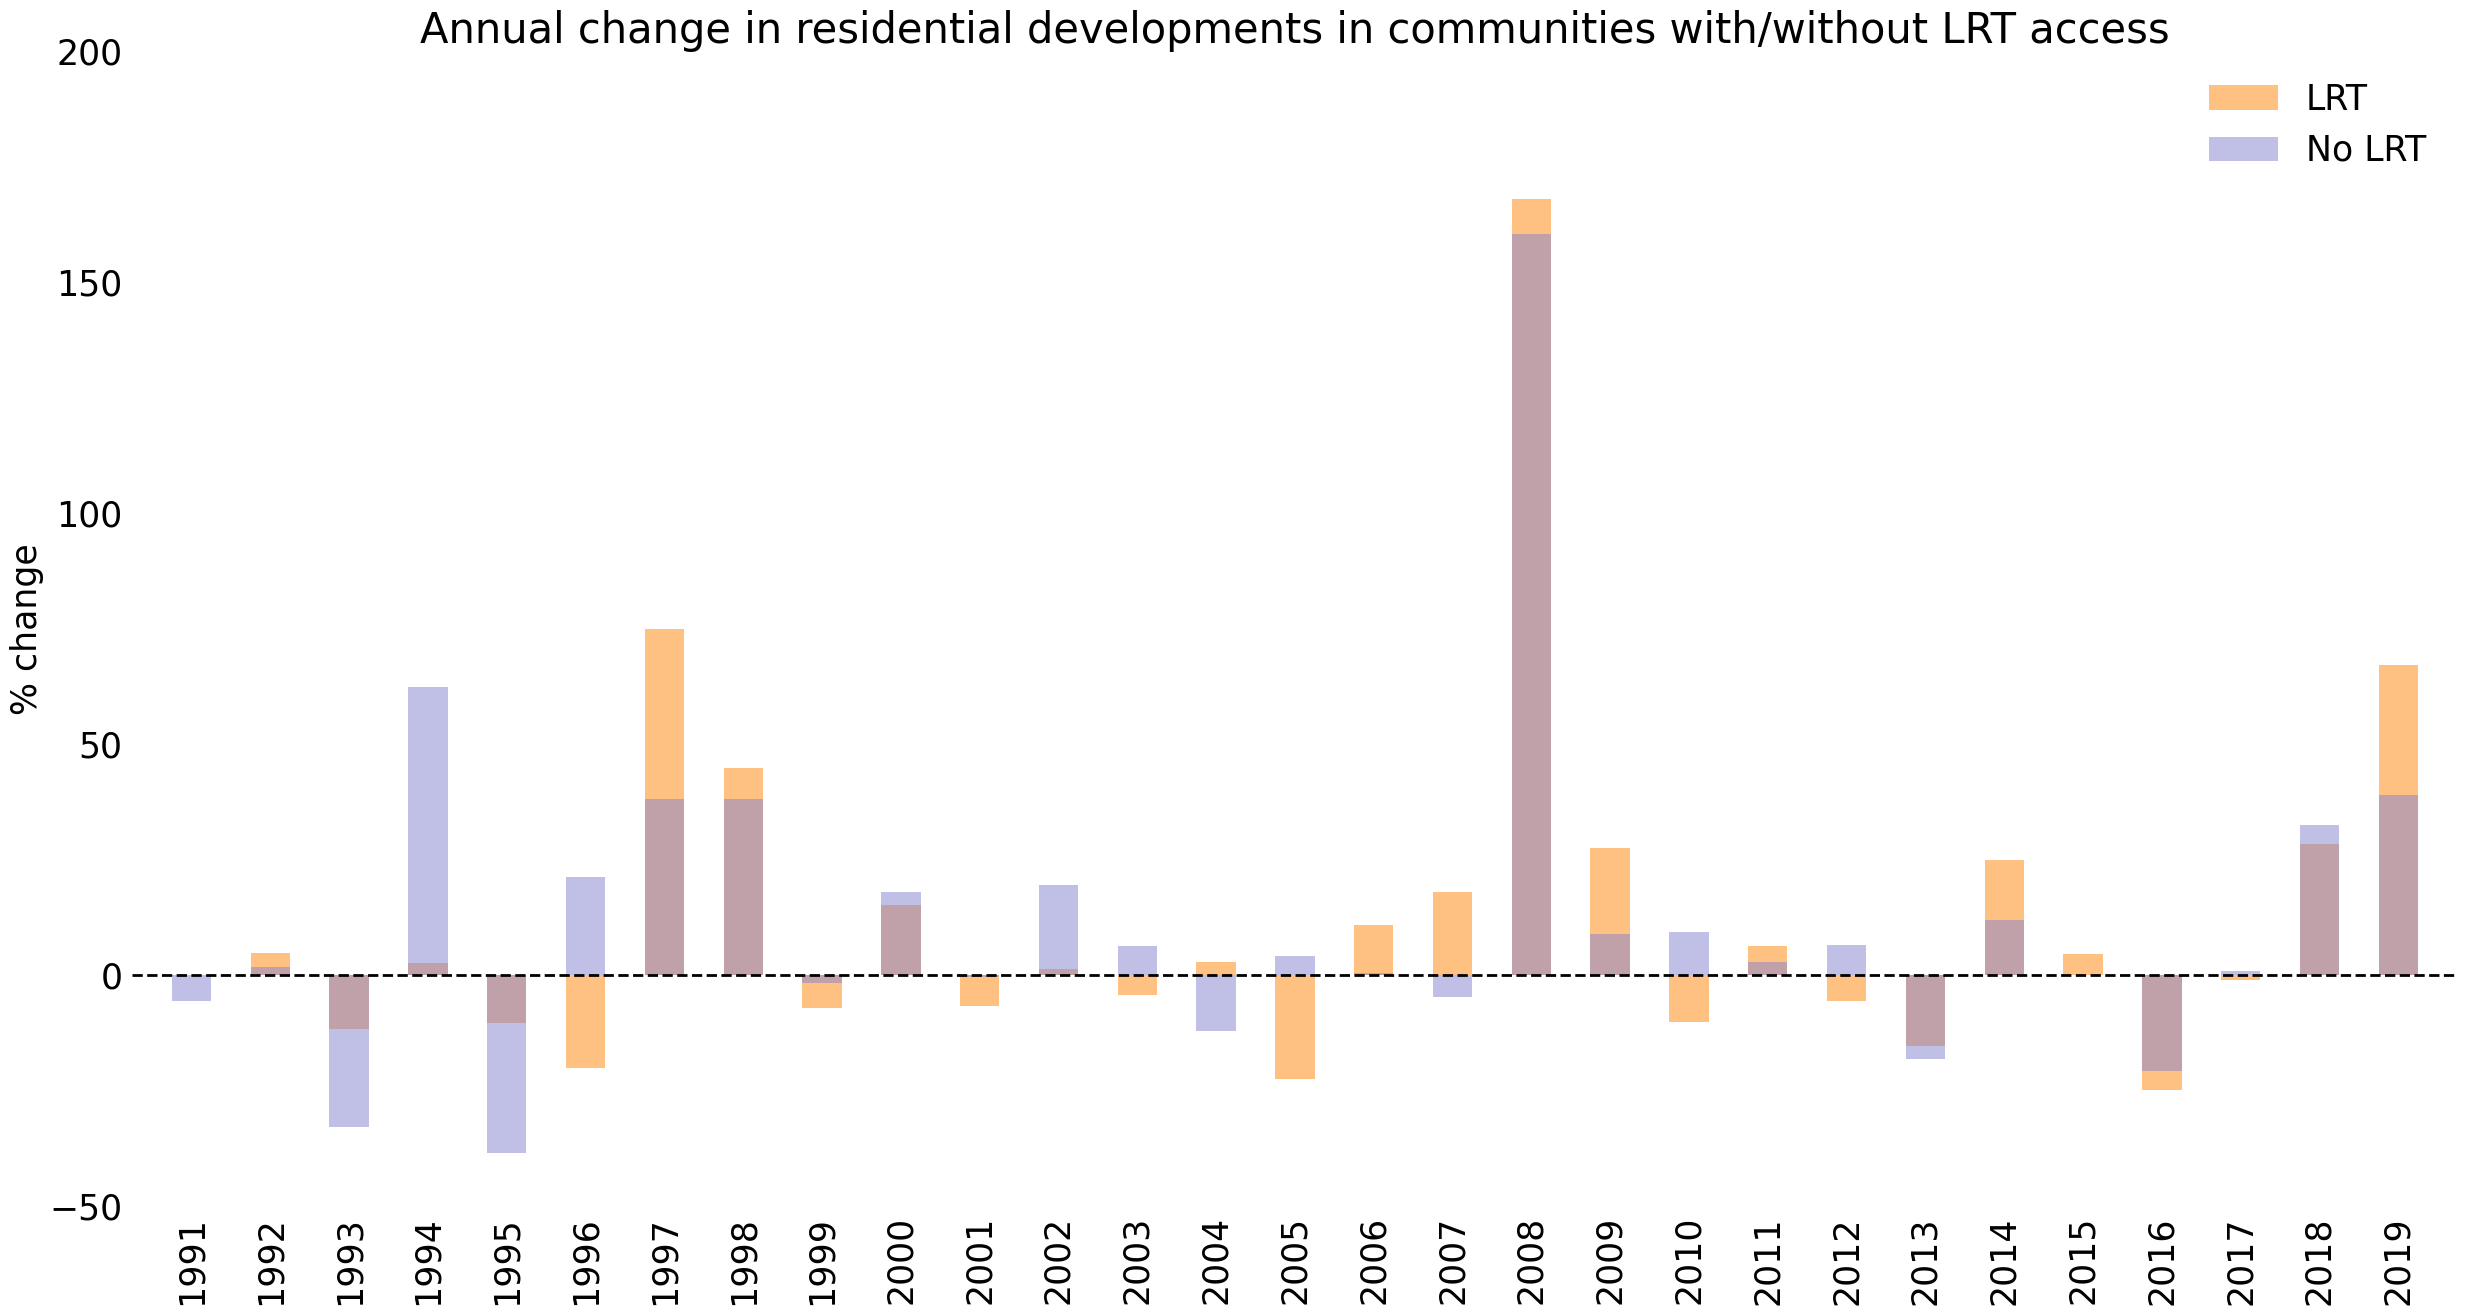

In [5]:
# Set x/y values and colours
lrt = growth_rates[True].tolist()
no_lrt = growth_rates[False].tolist()
years = growth_rates[False].index.tolist()

colour_1 = (255/255, 193/255, 130/255)
colour_2 = (130/255, 130/255, 208/255)

# Set the positioning parameters for each bar
n = len(years)
bar_pos = np.arange(n) + 0.75
tick_pos = range(1, n + 1)

# Plot the graph
plt.figure(figsize=(30,15), dpi=100)
plt.rcParams.update({'font.size': 25})
plt.bar(bar_pos, lrt, width=0.5, label='LRT', color=colour_1)
plt.bar(bar_pos, no_lrt, width=0.5, label='No LRT', color=colour_2,  alpha=0.5)
plt.title('Annual change in residential developments in communities with/without LRT access')
plt.ylabel('% change')
plt.ylim(-50, 200)
plt.xlim(0, 29.5)
plt.axhline(0,linestyle='dashed',linewidth=2,color='black')
plt.legend(frameon=False)

# Adapt the graph
ax = plt.gca()
ax.set_xticks(bar_pos)
ax.set_xticklabels(years, rotation=90)
utils.simplify(ax)

plt.savefig('figures/fig_1_growth_rates.png')
plt.show()


<b>Conclusion:</b> This bar graph shows that, in some years, there are some differences between LRT and non-LRT communities. Overall, however, no clear pattern favouring one or the other emerges. Specifically, LRT communities do not appear to be more sought-after than non-LRT communities. This suggests that factors other than LRT access greatly influence where residential development happens.

### Fig. 2: Absolute numbers by year and category 

One limitation of the analysis above is that a house or a secondary suite were considered equivalent to a multi-unit building, even though the latter houses more residents and represents a large investment into a community. This might have distorted the analysis, so in the following flow, each category will be examined separately.

In [6]:
grouped_by_type = pd.pivot_table(
    permits_residential_lt_1990,
    values='Decision',
    index=['Year'],
    columns=['Permit_category_new', 'CTrain'] ,
    aggfunc='count',
)

grouped_by_type.head()


Permit_category_new House       Multi_unit       Secondary_suite      
CTrain              False True       False True            False True 
Year                                                                  
1990                 71.0  21.0       53.0  20.0             NaN   NaN
1991                 77.0  20.0       40.0  21.0             NaN   NaN
1992                 71.0  26.0       48.0  17.0             NaN   NaN
1993                 52.0  22.0       28.0  16.0             NaN   NaN
1994                 84.0  27.0       46.0  12.0             NaN   NaN

In [7]:
grouped_by_type.tail()


Permit_category_new  House        Multi_unit       Secondary_suite       
CTrain               False  True       False True            False  True 
Year                                                                     
2015                 534.0  176.0       98.0  39.0           113.0   31.0
2016                 407.0  139.0      107.0  21.0            77.0   25.0
2017                 455.0  131.0       71.0  28.0            71.0   24.0
2018                 450.0  127.0       80.0  32.0           261.0   76.0
2019                 386.0  107.0       60.0  19.0           654.0  267.0

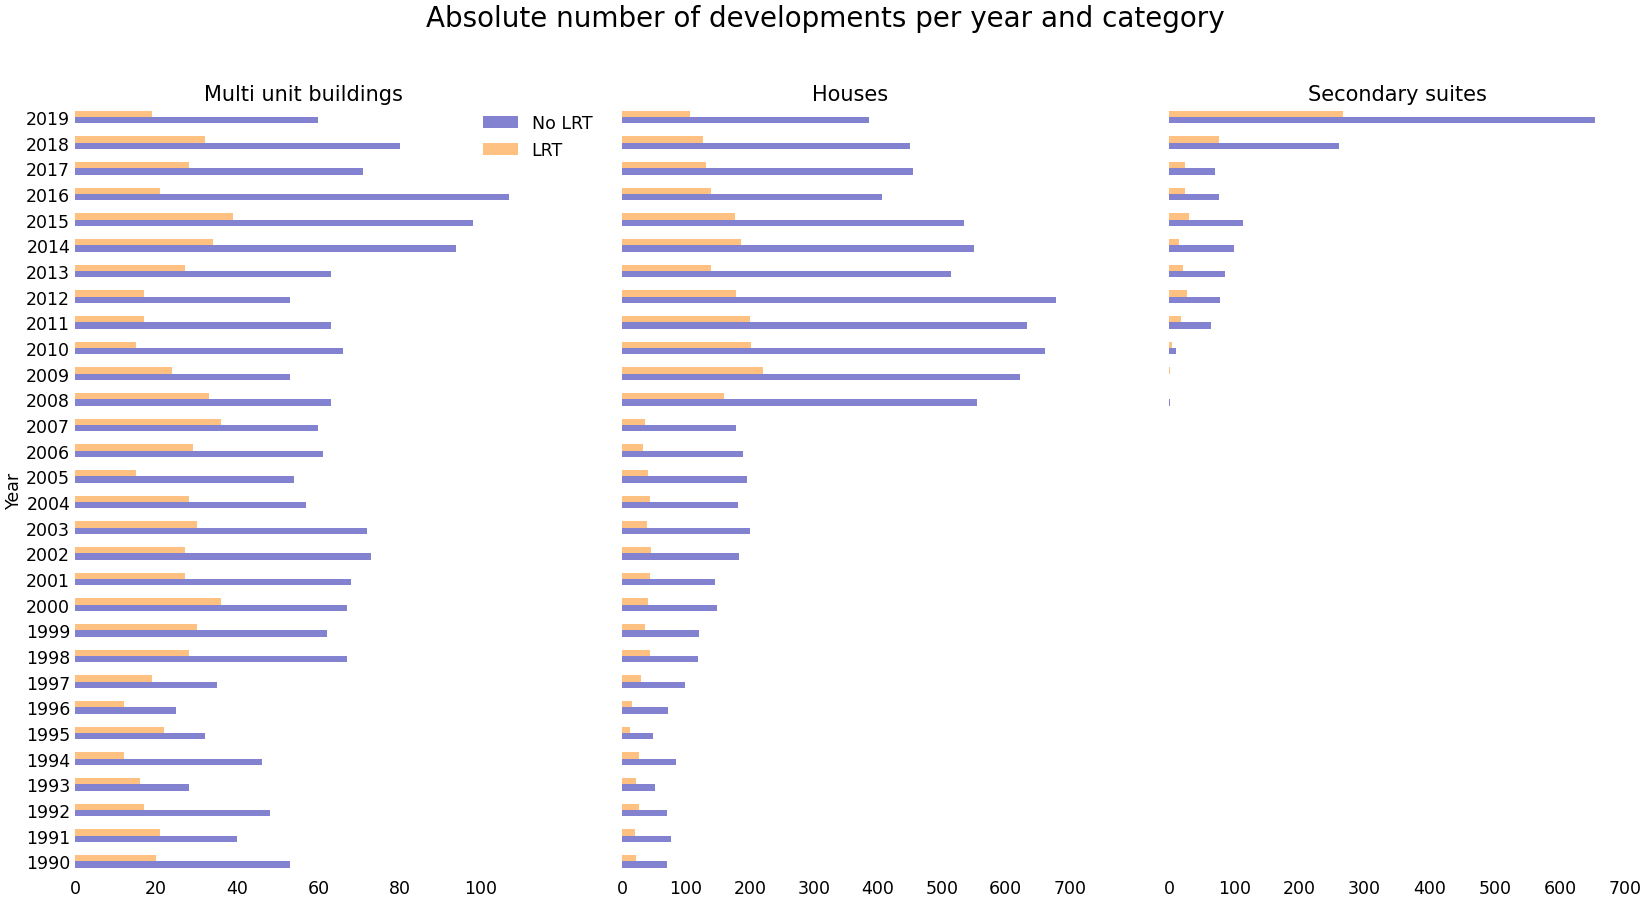

In [8]:
# Create figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40, 20), dpi=50, sharey=True)

plt.rcParams.update(
    {'font.size': 25}
)

# Plot multi unit
grouped_by_type['Multi_unit'].plot(kind='barh', color=[colour_2, colour_1], ax=ax1)
ax1.set_title('Multi unit buildings')
ax1.legend(
    loc='lower left',
    labels=['No LRT', 'LRT'],
    bbox_to_anchor=(0.88, 0.92),
    ncol=1, 
    borderaxespad=0,
    frameon=False,
)

# Plot houses
grouped_by_type['House'].plot(kind='barh', color=[colour_2, colour_1], ax=ax2)
ax2.set_title('Houses')
ax2.get_legend().remove()

# Plot secondary suites
grouped_by_type['Secondary_suite'].plot(kind='barh',  color=[colour_2, colour_1], ax=ax3)
ax3.set_title('Secondary suites')
ax3.get_legend().remove()
ax3.set_xlim(0, 700)

# Adapt graph style
for current_ax in [ax1, ax2, ax3]:
    utils.simplify(current_ax)

fig.suptitle('Absolute number of developments per year and category', fontsize=40)

plt.savefig('figures/fig_2_by_type.png')
plt.show()


<b>Conclusion:</b> In total, there is a much larger number of developments in non-LRT communities compared to LRT communities. Considering that Calgary's LRT system is composed of only two lines, and therefore doesn't serve most communities, this is not surprising per se. Interestingly, the absolute number of developments rises and falls quite similarly in LRT and non-LRT communities, again suggesting that factors other than acccess to transit drive the volume of developments. Crucially, this is the same for houses and multi-unit buildings.<br><br>
An interesting trend to note here is the sharp rise the numbers of secondary suites in 2018 and 2019.

## Plot building permits on a map

### Get geodata

In [9]:
# Import City of Calgary geodata
with open('data/Community Boundaries.geojson', 'r') as file:
    calgary_area = json.load(file)


### Check compatibility of geodata and permits data

In [10]:
# Extract community names from permits city of City of Calgary geodata
communities_in_permits = permits_residential_lt_1990['CommunityName'].unique()

# Extract community names in city of City of Calgary geodata
communities_in_geodata = []

for key in calgary_area['features']:
    name = key['properties']['name']
    communities_in_geodata.append(name)


In [11]:
# Check communities in GeoJSON data, but not in permits
values_without_geodata = set(communities_in_geodata)
values_without_geodata.difference_update(communities_in_permits)

print(values_without_geodata)


{'GREAT PLAINS', '12L', '12K', '06C', 'VALLEYFIELD', '03D', '12C', '05F', '12I', 'UNIVERSITY OF CALGARY', 'BURNS INDUSTRIAL', '10E', 'SKYLINE EAST', '01K', 'STONEY 3', 'GOLDEN TRIANGLE', 'MACEWAN GLEN', 'HOMESTEAD', '09Q', 'SOUTH AIRWAYS', 'MANCHESTER INDUSTRIAL', '01B', '09P', 'WOLF WILLOW', '09K', '10D', 'EASTFIELD', 'STONEY 2', 'CALGARY INTERNATIONAL AIRPORT', '12J', '05E', '02L', 'HORIZON', 'SCARBORO/ SUNALTA WEST', 'WESTWINDS', 'PEGASUS', 'GLENMORE PARK', '13M', '01C', '09O', 'STONEY 1', 'FOOTHILLS', 'BELVEDERE', 'SOUTH FOOTHILLS', 'DEERFOOT BUSINESS CENTRE', '12A', 'SKYLINE WEST', '13B', '13L', 'AURORA BUSINESS PARK', 'FAIRVIEW INDUSTRIAL', 'GREENVIEW INDUSTRIAL PARK', 'SADDLE RIDGE INDUSTRIAL', '06B', '13E', '06A', '12B', '01H', 'NOSE HILL PARK', 'OGDEN SHOPS', 'RANGEVIEW', 'MCCALL', 'CANADA OLYMPIC PARK', 'STONEY 4', '02B', '13G', 'MAYLAND', 'SHEPARD INDUSTRIAL', 'GLENDEER BUSINESS PARK', '13I', 'EAST FAIRVIEW INDUSTRIAL', 'SECTION 23', 'STARFIELD', 'ROYAL VISTA', 'KEYSTONE HIL

In [12]:
# Adjust CommunityName column in permits data to match with naming in geodata
community_mapping = {
    'NORTH GLENMORE' : 'GLENMORE PARK',
    'PARKHILL/STANLEY PARK' : 'PARKHILL',
    'CONNAUGHT' : 'BELTLINE',
    'CFB - LINCOLN PARK PMQ' : 'LINCOLN PARK',
    'CFB - CURRIE' : 'CURRIE BARRACKS',
    'VICTORIA PARK' : 'BELTLINE',
    'SCARBORO/SUNALTA WEST' : 'SCARBORO/ SUNALTA WEST',
    'MOUNT ROYAL LOWER' : 'LOWER MOUNT ROYAL',
    'MACEWAN' : 'MACEWAN GLEN' 
}

permits_residential_lt_1990['CommunityName'].replace(
    community_mapping,
    inplace=True,
)


### Fig. 3: Visualise as a point map

(N.B.: Code has been commented since the map takes long to load)

In [13]:
# Create base map of Calgary
yyc_point_map = folium.Map(location=[51.0447,-114.0719], tiles='Stamen Toner', zoom_start=10)

# Overlay community boundaries
community_style_props = {'fillColor': '#9a9a9a', 'color': '#9a9a9a'} 

folium.GeoJson(calgary_area, style_function=lambda x: community_style_props).add_to(yyc_point_map)


In [14]:
# Making a basic point map, i.e. plotting each permit as a point

marker_props = {
    'radius': 1,
    'weight': 1,
    'color': 'black',
    'fill_color': 'black',
    'fill_opacity': .25,
}

for _, row in permits_residential_lt_1990.iterrows():
    folium.CircleMarker(
        (
            row.Latitude,
            row.Longitude
        ),
        **marker_props,
    ).add_to(yyc_point_map)


In [15]:
yyc_point_map.save('figures/fig_3_dynamic_point_map.html')

point_map_image_data = yyc_point_map._to_png()
static_point_map = Image.open(io.BytesIO(point_map_image_data))
static_point_map.save('figures/fig_3_static_point_map.png')


<img src="figures/fig_3_static_point_map.png" width="600"/>

A point map is not suited for this visualisation, because it is too crowded. Instead, a choropleth map will be used to plot the density per community.

**N.B.:** Since GitHub does not render folium maps, a static version is shown here. Check the HTML files in `figures/` for the dynamic map.

### Fig. 4: Visualise with a choropleth map

In [16]:
# Aggregate by community name and project type
counts_by_community = permits_residential_lt_1990.groupby('CommunityName').count()['Decision'].rename('Count')

# Create basic map of Calgary and its communities
yyc_choropleth = folium.Map(location=[51.0447,-114.0719], tiles='Stamen Toner', zoom_start=10)

# Plot density of permits
bins = np.linspace(1, counts_by_community.max(), 10).round().tolist()

choropleth_props = {
    'key_on': 'feature.properties.name',
    'fill_color': 'Blues',
    'fill_opacity': .8,
    'line_opacity': 0.2,
    'legend_name': 'Permits',
    'nan_fill_color' :  'white',
    'nan_fill_opacity': 0,
    'bins':  bins,
    'highlight': True,
}

choropleth_layer = folium.Choropleth(
    geo_data=calgary_area,
    data=counts_by_community,
    **choropleth_props,
).add_to(yyc_choropleth)

folium.GeoJsonTooltip(
    fields=['name'],
    labels=False,
).add_to(choropleth_layer.geojson)


#### Add train stations and train lines

In [17]:
# Load station data
stations = pd.read_csv('data/Transit_LRT_Stations.csv')

# Convert coordinates stored as string to tuple
stations['location'] = stations['location'].apply(eval)

stations.head()


,STATIONNAM,LEG,DIRECTION,DIST_NB,DIST_SB,DIST_EB,DIST_WB,ROUTE,STATUS,longitude,latitude,location
0,Chinook,SW,North/South,2299.0,2200.0,0.0,0.0,201,Current,-114.065809,50.996808,"(50.996807857737046, -114.06580853211398)"
1,Zoo,NE,East/West,0.0,0.0,1379.0,1100.0,202,Current,-114.024856,51.047369,"(51.04736922517619, -114.02485607969437)"
2,6 St SW,DTEastbnd,East,0.0,0.0,414.0,410.0,201/202,Current,-114.075085,51.046773,"(51.04677318388097, -114.07508481556182)"
3,Sunalta,West,West/East,NaN,NaN,NaN,NaN,202,Current,-114.099135,51.044818,"(51.04481812949617, -114.09913462976633)"
4,Victoria Park / Stampede,SW,North/South,1027.0,725.0,0.0,0.0,201,Current,-114.058308,51.038580,"(51.03858013717659, -114.05830814657534)"


In [18]:
# Extract stations on 'Red Line', then sort North to South, since this is the primary direction the line runs
red_line = stations[
    (stations.ROUTE == '201') | (stations.ROUTE == '201/202')
].sort_values(['latitude'])

# Sorting failed for downtown stations, manually reorder downtown Red Line stations
red_line_adjusted_index = [13, 19, 25, 15, 24, 40, 45, 0, 32, 37, 4, 31, 27, 18, 20,
                           7, 26, 2, 11, 22, 35, 9, 21, 46, 33, 43, 6, 10, 14]
red_line = red_line.reindex(red_line_adjusted_index)

#  Draw train line
folium.PolyLine(
    red_line['location'].tolist(),
    color='red',
    weight=3,
    tooltip='Red Line',
).add_to(yyc_choropleth)

# Plot stations
for _, row in red_line.iterrows():
    folium.CircleMarker(
        row.location, 
        radius=2, 
        weight=2,
        color='black',
        tooltip = row.STATIONNAM,
        fill_color='black', fill_opacity=1
    ).add_to(yyc_choropleth)


In [19]:
# Extract stations on 'Blue Line', then sort East-West, since this is the primary direction the line runs
blue_line = stations[
    (stations.ROUTE == '202') | (stations.ROUTE == '201/202')
].sort_values(['longitude'])

# Sorting failed for downtown stations, manually reorder downtown Blue Line stations
blue_line_adjusted_index = [38, 34, 30, 41, 17, 3, 36, 28, 22, 11, 2, 26, 7, 20,
                            18, 27, 31, 44, 1, 39, 29, 8, 12, 16, 42, 23, 5]
blue_line = blue_line.reindex(blue_line_adjusted_index)

# Draw train line
folium.PolyLine(
    blue_line['location'].tolist(),
    color='blue',
    weight=3,
    tooltip = 'Blue Line',
).add_to(yyc_choropleth)

# Plot stations
for _, row in blue_line.iterrows():
    folium.CircleMarker(
        row.location, 
        radius=2, 
        weight=2,
        color='black',
        tooltip = row.STATIONNAM,
        fill_color='black',
        fill_opacity=1
    ).add_to(yyc_choropleth)


In [21]:
yyc_choropleth.save('figures/fig_4_dynamic_choropleth_map.html')

choropleth_image_data = yyc_choropleth._to_png()
static_choropleth = Image.open(io.BytesIO(choropleth_image_data))
static_choropleth.save('figures/fig_4_static_choropleth_map.png')


<img src="figures/fig_4_static_choropleth_map.png" width="600"/>

**N.B.:** Since GitHub does not render foliu m maps, a static version is shown here. Check the HTML files in `figures/` for the dynamic map.

<b>Conclusion:</b> In line with figures 1 and 2, this map shows that communities with direct LRT access do not always see greater levels of residential development than communities without LRT access. Interestingly though, the choropleth map reveals a trend that was not captured in the bar charts: The areas with the highest levels of developments are in close proximity to the train lines, and developments gradually decrease further away from the two lines.